In [70]:
import requests
from PIL import Image
from pprint import pprint
import json
import pandas as pd
import ipyplot
from IPython.display import Markdown, display

In [2]:
api_key = "vytvIDyAwxQXP87gn0Defwiltz4391uInF8bObyE"
url_weather = "https://api.nasa.gov/insight_weather/?"
url_images = "https://api.nasa.gov/mars-photos/api/v1/rovers/{}/photos?"
rovers = ["curiosity"]#, "opportunity", "spirit"]
# All cameras with the exception of MARDI - The Mars Descent Imager (as there are no photos for any day aside from the descent date)
curiosity_cameras = ["FHAZ", "RHAZ", "MAST",
                     "CHEMCAM","MAHLI", "NAVCAM"]
# [url_images.format(x) for x in rovers]
# API Mars Weather Docs: https://api.nasa.gov/assets/insight/InSight%20Weather%20API%20Documentation.pdf

In [3]:
payload_weather = {
    "api_key": api_key,
    "feedtype": "json"
}
payload_images = {
    "api_key": api_key#"DEMO_KEY"
}

In [4]:
# resp = requests.get(url, params=payload)
resp = requests.get(url_weather, params=payload_weather)

In [5]:
def get_weather(url_weather, payload):
    resp = requests.get(url_weather, params=payload)
    return json.loads(resp.content)

def get_images(url_images, rover, day, payload):
    print("Getting the images for {} rover on Day {}.".format(
    rover, day[:10]
    ))
    payload_sol = payload
    payload_sol["earth_date"] = day[:10]
    rover_url = url_images.format(rover)
    resp = requests.get(rover_url, params=payload_sol)
    return json.loads(resp.content)

def get_images_on_day_list(images_json):
    photos = images_json["photos"]
    first_images = []
    for camera in curiosity_cameras:
        first_image = "None Found"
        for photo in photos:
            if photo["camera"]["name"] == camera:
                first_image = photo["img_src"]
                break
        first_images.append({
            camera: first_image
        })
    return first_images

def combine_to_dict(day_images):
    full_dict = {}
    for camera in curiosity_cameras:
        full_dict[camera] = []
    for day in day_images:
        for camera in day:
            cam = list(camera.keys())[0]
            full_dict[cam].append(camera[cam])
    return full_dict

def get_images_df(url, days, rover, payload):
    day_images = []
    for day in days:
        day_images.append(
            get_images_on_day_list(
                get_images(url, rover, day, payload)))
    return pd.DataFrame(combine_to_dict(day_images))

In [6]:
# resp.content

In [7]:
cont = json.loads(resp.content)
cont2 = {
    key: cont[key] for key in list(cont.keys())[:-2]
}
cont_pd = pd.DataFrame(cont2)
cont['812']

{'First_UTC': '2021-03-09T12:55:49Z',
 'Last_UTC': '2021-03-10T13:35:24Z',
 'Month_ordinal': 12,
 'Northern_season': 'late winter',
 'PRE': {'av': 727.699, 'ct': 105992, 'mn': 706.365, 'mx': 742.9495},
 'Season': 'winter',
 'Southern_season': 'late summer',
 'WD': {'most_common': None}}

In [8]:
weather = []
for key,val in cont2.items():
    pre = val["PRE"]
    del val["PRE"]
    del val["WD"]
    val = {**val, **pre}
    updated = {**{"Sol":key}, **val}
    weather.append(updated)
# weather

In [9]:
weather_pd = pd.DataFrame(weather)
new_order = ["Sol"] + [x for x in weather_pd.columns.tolist() if x != "Sol"]
weather_pd = weather_pd[new_order]

In [10]:
weather_pd

,Sol,First_UTC,Last_UTC,Month_ordinal,Northern_season,Season,Southern_season,av,ct,mn,mx
0,812,2021-03-09T12:55:49Z,2021-03-10T13:35:24Z,12,late winter,winter,late summer,727.699,105992,706.3650,742.9495
1,813,2021-03-10T13:35:28Z,2021-03-11T14:14:59Z,12,late winter,winter,late summer,727.909,100620,706.2391,743.8608
2,814,2021-03-11T14:15:03Z,2021-03-12T14:54:34Z,12,late winter,winter,late summer,728.121,104121,706.9009,745.4649
3,815,2021-03-12T14:54:38Z,2021-03-13T15:34:09Z,12,late winter,winter,late summer,728.378,153082,708.4211,744.9279
4,818,2021-03-15T20:01:49Z,2021-03-16T17:32:54Z,12,late winter,winter,late summer,727.696,109855,710.2230,743.9460


In [11]:
days = weather_pd.First_UTC

In [12]:
days

0    2021-03-09T12:55:49Z
1    2021-03-10T13:35:28Z
2    2021-03-11T14:15:03Z
3    2021-03-12T14:54:38Z
4    2021-03-15T20:01:49Z
Name: First_UTC, dtype: object

In [13]:
images_json = get_images(url_images,rovers[0],days[0],payload_images)

Getting the images for curiosity rover on Day 2021-03-09.


In [26]:
images_json["photos"][0]

{'id': 814302,
 'sol': 3054,
 'camera': {'id': 20,
  'name': 'FHAZ',
  'rover_id': 5,
  'full_name': 'Front Hazard Avoidance Camera'},
 'img_src': 'https://mars.nasa.gov/msl-raw-images/proj/msl/redops/ods/surface/sol/03054/opgs/edr/fcam/FLB_668625168EDR_F0870792FHAZ00337M_.JPG',
 'earth_date': '2021-03-09',
 'rover': {'id': 5,
  'name': 'Curiosity',
  'landing_date': '2012-08-06',
  'launch_date': '2011-11-26',
  'status': 'active'}}

In [15]:
pd.DataFrame(images_json["photos"])

,id,sol,camera,img_src,earth_date,rover
0,814302,3054,"{'id': 20, 'name': 'FHAZ', 'rover_id': 5, 'ful...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-09,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
1,814303,3054,"{'id': 20, 'name': 'FHAZ', 'rover_id': 5, 'ful...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-09,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
2,814304,3054,"{'id': 20, 'name': 'FHAZ', 'rover_id': 5, 'ful...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-09,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
3,814305,3054,"{'id': 20, 'name': 'FHAZ', 'rover_id': 5, 'ful...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-09,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
4,814306,3054,"{'id': 20, 'name': 'FHAZ', 'rover_id': 5, 'ful...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-09,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
...,...,...,...,...,...,...
230,814631,3054,"{'id': 26, 'name': 'NAVCAM', 'rover_id': 5, 'f...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-09,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
231,814632,3054,"{'id': 26, 'name': 'NAVCAM', 'rover_id': 5, 'f...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-09,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
232,814633,3054,"{'id': 26, 'name': 'NAVCAM', 'rover_id': 5, 'f...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-09,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
233,814634,3054,"{'id': 26, 'name': 'NAVCAM', 'rover_id': 5, 'f...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-09,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."


In [16]:
one_day = get_images_on_day_list(images_json)

In [17]:
pd.DataFrame(combine_to_dict([one_day]))

,FHAZ,RHAZ,MAST,CHEMCAM,MAHLI,NAVCAM
0,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,None Found,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...


In [18]:
images_df = get_images_df(url_images,days,rovers[0],payload_images)

Getting the images for curiosity rover on Day 2021-03-09.
Getting the images for curiosity rover on Day 2021-03-10.
Getting the images for curiosity rover on Day 2021-03-11.
Getting the images for curiosity rover on Day 2021-03-12.
Getting the images for curiosity rover on Day 2021-03-15.


In [19]:
images_df

,FHAZ,RHAZ,MAST,CHEMCAM,MAHLI,NAVCAM
0,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,None Found,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...
1,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...
2,None Found,None Found,None Found,None Found,None Found,None Found
3,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,None Found,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...
4,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...


In [20]:
full_df = weather_pd.join(images_df)

In [34]:
full_df.First_UTC = pd.to_datetime(full_df.First_UTC)
full_df.Last_UTC = pd.to_datetime(full_df.Last_UTC)
full_df

,Sol,First_UTC,Last_UTC,Month_ordinal,Northern_season,Season,Southern_season,av,ct,mn,mx,FHAZ,RHAZ,MAST,CHEMCAM,MAHLI,NAVCAM
0,812,2021-03-09 12:55:49+00:00,2021-03-10 13:35:24+00:00,12,late winter,winter,late summer,727.699,105992,706.3650,742.9495,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,None Found,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...
1,813,2021-03-10 13:35:28+00:00,2021-03-11 14:14:59+00:00,12,late winter,winter,late summer,727.909,100620,706.2391,743.8608,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...
2,814,2021-03-11 14:15:03+00:00,2021-03-12 14:54:34+00:00,12,late winter,winter,late summer,728.121,104121,706.9009,745.4649,None Found,None Found,None Found,None Found,None Found,None Found
3,815,2021-03-12 14:54:38+00:00,2021-03-13 15:34:09+00:00,12,late winter,winter,late summer,728.378,153082,708.4211,744.9279,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,None Found,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...
4,818,2021-03-15 20:01:49+00:00,2021-03-16 17:32:54+00:00,12,late winter,winter,late summer,727.696,109855,710.2230,743.9460,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...


#### **Sol 812**


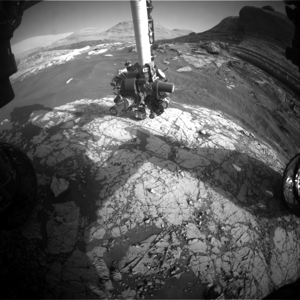
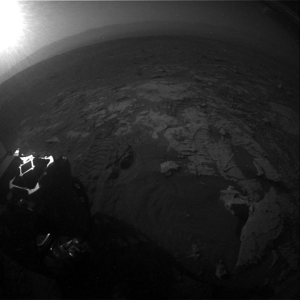
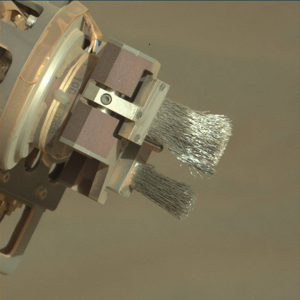
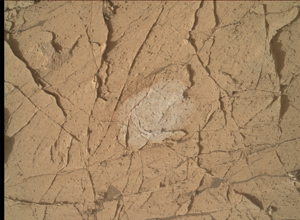
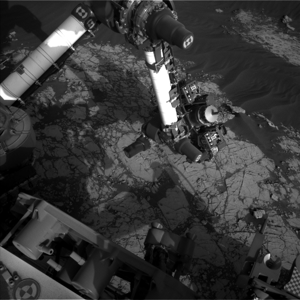


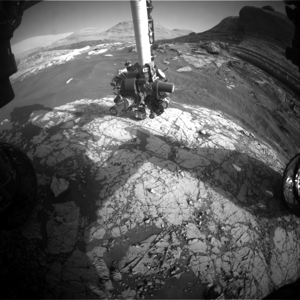
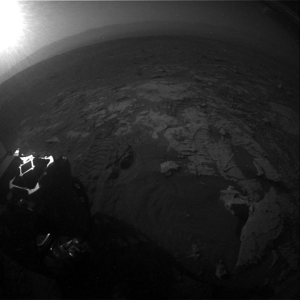
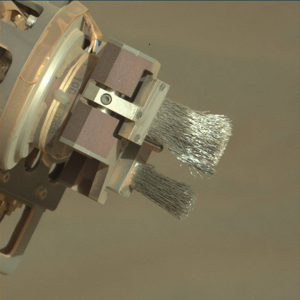
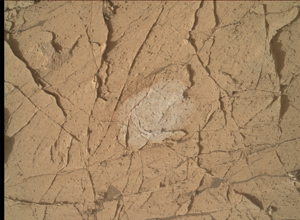
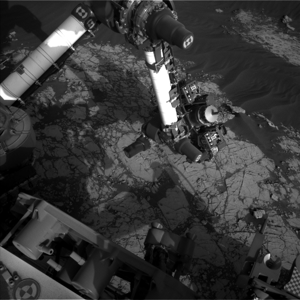

#### **Sol 813**


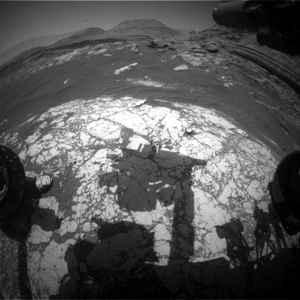
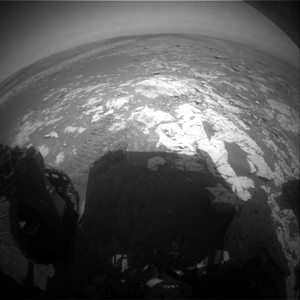
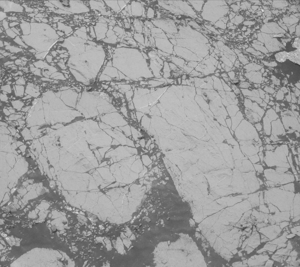
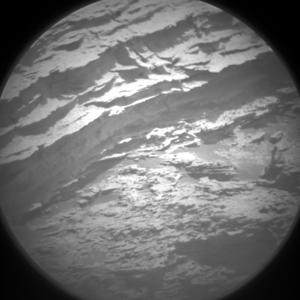
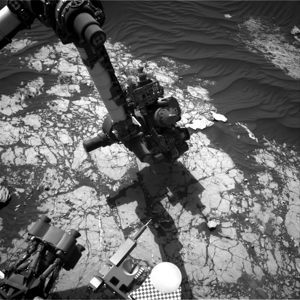


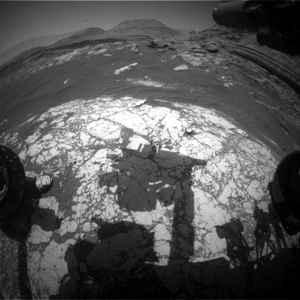
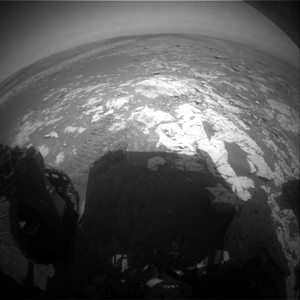
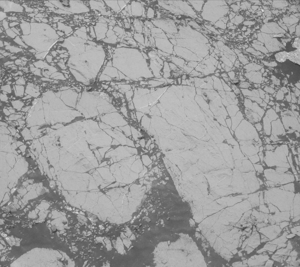
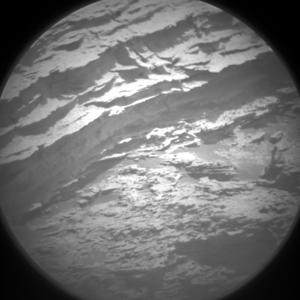
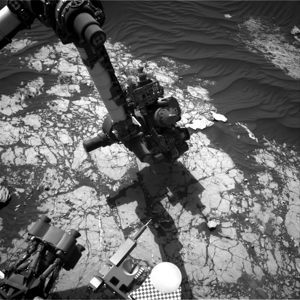

#### **Sol 814**

**None Found**

#### **Sol 815**


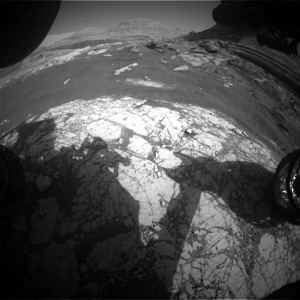
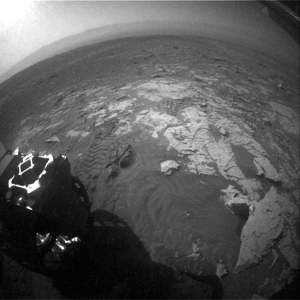
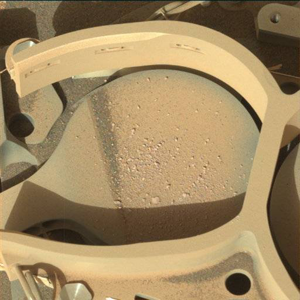
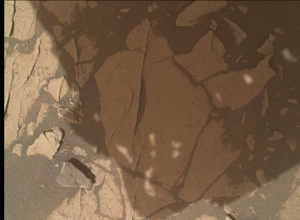
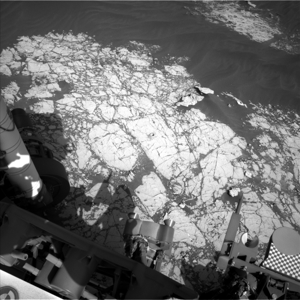


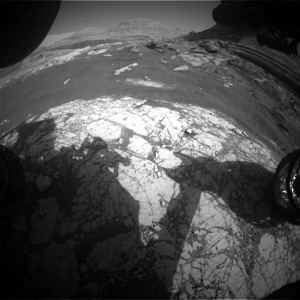
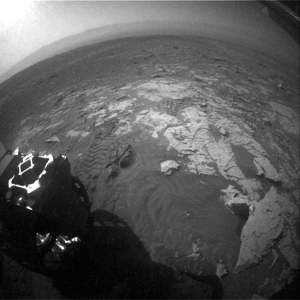
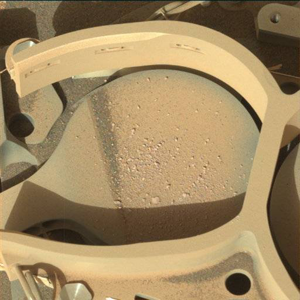
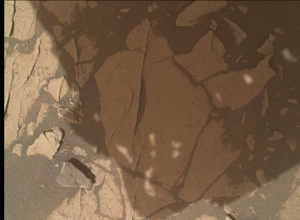
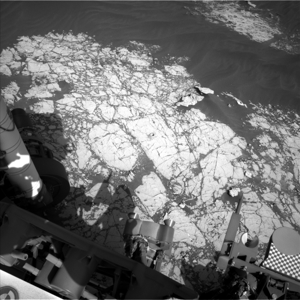

#### **Sol 818**


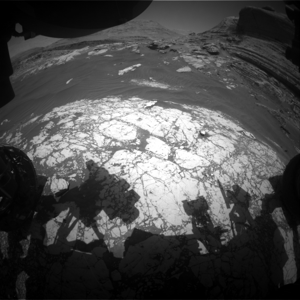
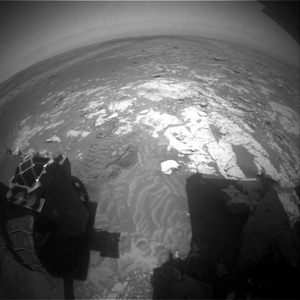
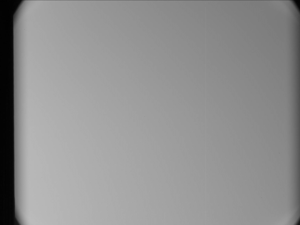
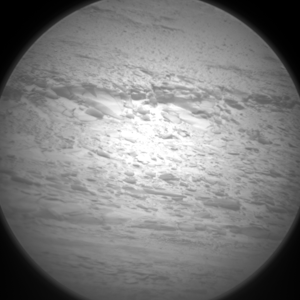
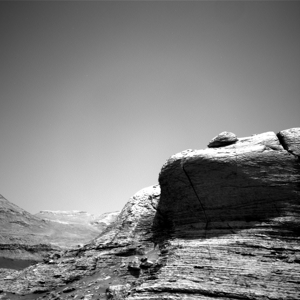


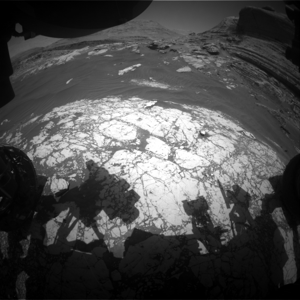
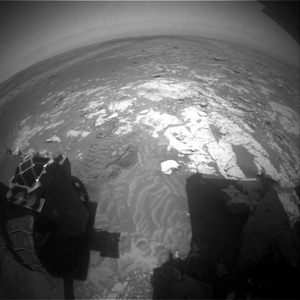
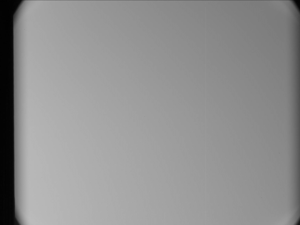
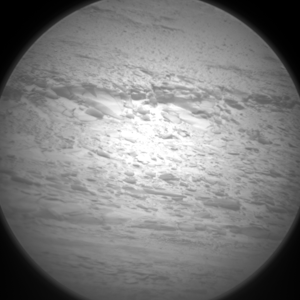
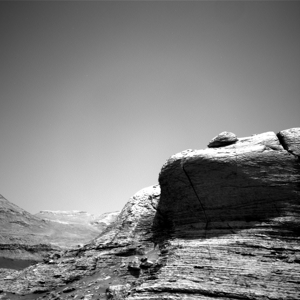

In [80]:
# Display all of the available images along the pressure information for that day
for _,row in full_df.iterrows():
    
    ## Matplotlib goes here
    
    images_array = []
    labels_array = []
    for i,download_url in enumerate(row[11:]):
        if not download_url == "None Found":
            images_array.append(Image.open(requests.get(download_url, stream=True).raw))
            labels_array.append(row.index[i+11])
    display(Markdown(f"#### **Sol {row.Sol}**"))
    if len(images_array) > 0:
        ipyplot.plot_images(images_array, labels_array, img_width=300)
    else:
        display(Markdown("**None Found**"))